# AgriAssistant: Fine-Tuning a Domain-Specific LLM for Agriculture

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1FPaCRRHxMapKkS6_82rR-fYpvXbOv_5N)

---

## Project Overview

This notebook implements a complete, end-to-end pipeline for fine-tuning a Large Language Model to serve as an agricultural domain expert. The assistant is capable of answering questions on crop management, soil health, pest control, irrigation, fertilization, and sustainable farming practices.

**Domain:** Agriculture  
**Base Model:** `TinyLlama/TinyLlama-1.1B-Chat-v1.0`  
**Dataset:** `ashraq/agri-qa` from Hugging Face Datasets Hub  
**Fine-tuning Strategy:** QLoRA (4-bit quantization + Low-Rank Adaptation via `peft`)  
**Deployment:** Gradio web interface  
**Hardware:** Google Colab T4 GPU (Free Tier)  

### Why TinyLlama?
TinyLlama-1.1B-Chat is a strong choice for constrained hardware fine-tuning. At 1.1 billion parameters it fits comfortably in a T4 GPU's 15 GB VRAM under 4-bit quantization, it is already instruction-tuned using the ChatML format, and it achieves competitive performance relative to its size. Combined with LoRA, only approximately 1.5% of parameters are trainable, keeping memory usage under 10 GB.

### Pipeline Structure

| Section | Description |
|---------|-------------|
| 1 | Imports and Environment Setup |
| 2 | Google Drive Mount and Directory Setup |
| 3 | Dataset Loading and Exploratory Data Analysis |
| 4 | Data Preprocessing and Instruction Formatting |
| 5 | Tokenizer Setup and Sequence Length Analysis |
| 6 | Model Loading with 4-bit Quantization |
| 7 | LoRA Configuration and Parameter-Efficient Fine-Tuning Setup |
| 8 | Training Configuration and Model Training |
| 9 | Model Evaluation: BLEU, ROUGE, Perplexity |
| 10 | Base vs Fine-Tuned Model Comparison |
| 11 | Qualitative Testing and Out-of-Domain Analysis |
| 12 | Gradio Deployment Interface |
| 13 | Final Summary and Results |

### Author: Edine Noella Mugisha

## Section 1: Imports and Environment Setup


In [3]:
# Install packages that are not guaranteed to be present in all Colab environments.
# peft, trl, bitsandbytes, and evaluate are not part of the default Colab image.
!pip install -q peft trl bitsandbytes accelerate evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.2 MB/s eta 0:00:00


In [4]:
# Standard library
import os
import json
import time
import random
import warnings

# Scientific computing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP utilities
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Deep learning
import torch

# Hugging Face ecosystem
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    set_seed,
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel,
    prepare_model_for_kbit_training,
)
from trl import SFTTrainer, SFTConfig
import evaluate

warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Global constants
MODEL_NAME  = 'TinyLlama/TinyLlama-1.1B-Chat-v1.0'
MAX_SEQ_LEN = 512
DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Imports complete.')
print(f'Device  : {DEVICE}')
print(f'PyTorch : {torch.__version__}')
if DEVICE == 'cuda':
    print(f'GPU     : {torch.cuda.get_device_name(0)}')
    total_vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f'VRAM    : {total_vram:.1f} GB')

Imports complete.
Device  : cuda
PyTorch : 2.10.0+cu128
GPU     : Tesla T4
VRAM    : 15.6 GB


In [ ]:
# Verify GPU is available. If this shows no GPU, go to:
# Runtime -> Change runtime type -> Hardware accelerator -> T4 GPU
import subprocess
result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
if result.returncode == 0:
    print(result.stdout)
else:
    print('No GPU detected. Please enable T4 GPU in Runtime settings before proceeding.')

Thu Feb 19 08:12:05 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Section 2: Google Drive Mount and Directory Setup

All outputs — the fine-tuned model weights, tokenizer, evaluation results, and plots — are saved to Google Drive. This is because Colab sessions reset after inactivity, and training takes 45-90 minutes. Saving to Drive ensures nothing is lost between sessions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_DIR = '/content/drive/MyDrive/AgriAssistant'
MODEL_DIR   = f'{PROJECT_DIR}/models/agri-tinyllama-lora'
RESULTS_DIR = f'{PROJECT_DIR}/results'
DATA_DIR    = f'{PROJECT_DIR}/data'

for directory in [MODEL_DIR, RESULTS_DIR, DATA_DIR]:
    os.makedirs(directory, exist_ok=True)

print('Google Drive mounted successfully.')
print(f'Project root : {PROJECT_DIR}')
print(f'  models/    : fine-tuned model weights and tokenizer')
print(f'  results/   : evaluation metrics, plots, and qualitative outputs')
print(f'  data/      : processed dataset splits')

Mounted at /content/drive
Google Drive mounted successfully.
Project root : /content/drive/MyDrive/AgriAssistant
  models/    : fine-tuned model weights and tokenizer
  results/   : evaluation metrics, plots, and qualitative outputs
  data/      : processed dataset splits


## Section 3: Dataset Loading and Exploratory Data Analysis

We load the **AgriQA dataset** (`ashraq/agri-qa`) from Hugging Face Datasets Hub. This is a curated collection of agricultural question-answer pairs covering diverse farming topics including crop cultivation, soil science, pest management, irrigation, fertilization, and sustainable agriculture.

After loading, we perform exploratory data analysis to understand the structure, size, and characteristics of the data before preprocessing.

In [ ]:
# Load the AgriQA dataset directly from Hugging Face
print('Loading ashraq/agri-qa from Hugging Face Datasets Hub...')
raw_dataset = load_dataset('shchoi83/agriQA')

print('Dataset loaded.')
print(raw_dataset)

Loading ashraq/agri-qa from Hugging Face Datasets Hub...


Repo card metadata block was not found. Setting CardData to empty.


new_file_non.csv:   0%|          | 0.00/59.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/174930 [00:00<?, ? examples/s]

Dataset loaded.
DatasetDict({
    train: Dataset({
        features: ['questions', 'answers', 'text'],
        num_rows: 174930
    })
})


In [ ]:
# Identify the primary split and inspect the first few examples
split_name = list(raw_dataset.keys())[0]
main_split = raw_dataset[split_name]

print(f'Primary split  : {split_name}')
print(f'Number of rows : {len(main_split):,}')
print(f'Column names   : {main_split.column_names}')
print()

# Display the first three examples
print('--- First 3 examples ---')
for i in range(min(3, len(main_split))):
    print(f'\nExample {i+1}:')
    for col in main_split.column_names:
        value = str(main_split[i][col])
        display_value = value[:300] + '...' if len(value) > 300 else value
        print(f'  [{col}] {display_value}')

Primary split  : train
Number of rows : 174,930
Column names   : ['questions', 'answers', 'text']

--- First 3 examples ---

Example 1:
  [questions] asking about the control measure for aphid infestation in mustard crops
  [answers] suggested him to spray rogor@2ml/lit.at evening time.
  [text] Below are questions and answers about agriculture. Make sure you answer the questions. ###Q:asking about the control measure for aphid infestation in mustard crops###A:suggested him to spray rogor@2ml/lit.at evening time.

Example 2:
  [questions] asking about the control measure of flower drop problem in his coconut plant
  [answers] suggested him to apply fertilizer in recommended dose like urea-600gm,ssp-1kg,mop-700gm,borax-25gm twice in a year(march/april and september/october)followed by trench method and also suggested him to spray planofix@1teaspoonful per20-25 liter of water.
  [text] Below are questions and answers about agriculture. Make sure you answer the questions. ###Q:asking abou

In [ ]:
# Automatically identify the question and answer columns based on column names.
# The AgriQA dataset uses 'question' and 'answer' columns.

def identify_qa_columns(column_names):
    """Return (question_col, answer_col) by matching common naming patterns."""
    question_keywords = ['question', 'query', 'input', 'prompt', 'q']
    answer_keywords   = ['answer', 'response', 'output', 'completion', 'a']

    q_col = None
    a_col = None

    for col in column_names:
        col_lower = col.lower()
        if q_col is None and any(kw in col_lower for kw in question_keywords):
            q_col = col
        if a_col is None and any(kw in col_lower for kw in answer_keywords):
            a_col = col

    # Fallback: use first two string columns
    if q_col is None or a_col is None:
        str_cols = column_names[:2]
        if q_col is None: q_col = str_cols[0]
        if a_col is None and len(str_cols) > 1: a_col = str_cols[1]

    return q_col, a_col


QUESTION_COL, ANSWER_COL = identify_qa_columns(main_split.column_names)
print(f'Question column : "{QUESTION_COL}"')
print(f'Answer column   : "{ANSWER_COL}"')

Question column : "questions"
Answer column   : "answers"


In [ ]:
# Build a DataFrame for exploratory analysis
df = pd.DataFrame({
    'question': main_split[QUESTION_COL],
    'answer'  : main_split[ANSWER_COL]
})

# Cast to string and strip whitespace
df['question'] = df['question'].astype(str).str.strip()
df['answer']   = df['answer'].astype(str).str.strip()

# Drop rows where either field is empty or 'nan'
df = df[~df['question'].isin(['', 'nan', 'None'])]
df = df[~df['answer'].isin(['', 'nan', 'None'])]
df = df.reset_index(drop=True)

# Compute word counts
df['question_word_count'] = df['question'].apply(lambda x: len(x.split()))
df['answer_word_count']   = df['answer'].apply(lambda x: len(x.split()))

print('Dataset statistics after cleaning:')
print(f'  Total examples             : {len(df):,}')
print(f'  Question length (mean)     : {df["question_word_count"].mean():.1f} words')
print(f'  Question length (median)   : {df["question_word_count"].median():.0f} words')
print(f'  Question length (max)      : {df["question_word_count"].max()} words')
print(f'  Answer length (mean)       : {df["answer_word_count"].mean():.1f} words')
print(f'  Answer length (median)     : {df["answer_word_count"].median():.0f} words')
print(f'  Answer length (max)        : {df["answer_word_count"].max()} words')
print()
print(df[['question', 'answer', 'question_word_count', 'answer_word_count']].head(5).to_string(max_colwidth=80))

Dataset statistics after cleaning:
  Total examples             : 174,929
  Question length (mean)     : 7.1 words
  Question length (median)   : 7 words
  Question length (max)      : 139 words
  Answer length (mean)       : 13.6 words
  Answer length (median)     : 10 words
  Answer length (max)        : 1327 words

                                                                       question                                                                           answer  question_word_count  answer_word_count
0       asking about the control measure for aphid infestation in mustard crops                            suggested him to spray rogor@2ml/lit.at evening time.                   11                  7
1  asking about the control measure of flower drop problem in his coconut plant  suggested him to apply fertilizer in recommended dose like urea-600gm,ssp-1k...                   13                 30
2               asking about how to avail kisan credit card loan for sali cro

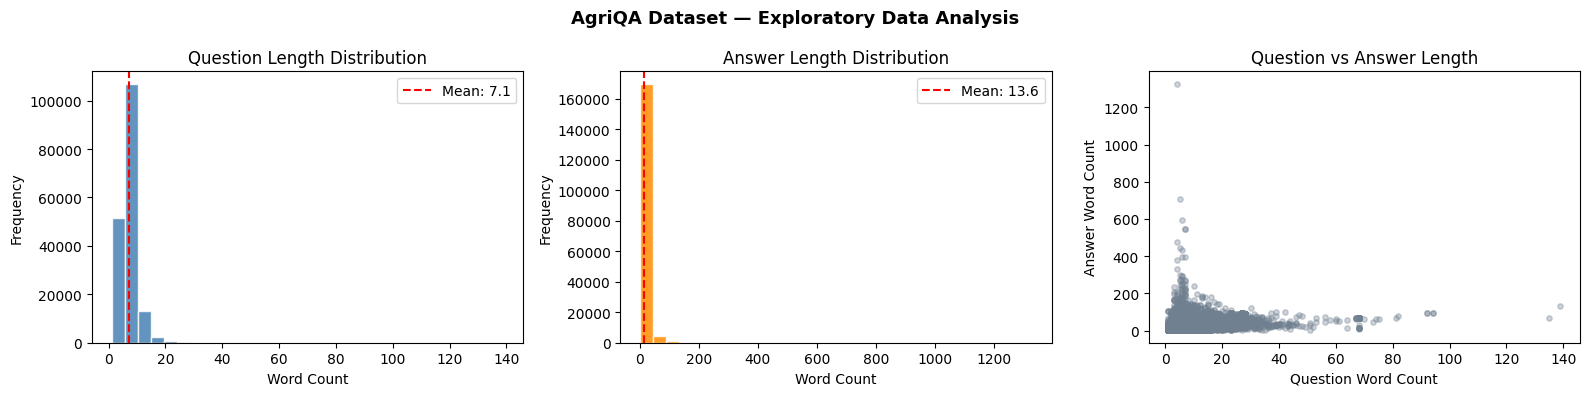

EDA plot saved to /content/drive/MyDrive/AgriAssistant/results/eda_length_distributions.png


In [ ]:
# Visualize the distribution of question and answer lengths
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('AgriQA Dataset — Exploratory Data Analysis', fontsize=13, fontweight='bold')

# Histogram: question word count
axes[0].hist(df['question_word_count'], bins=30, color='steelblue', edgecolor='white', alpha=0.85)
axes[0].axvline(df['question_word_count'].mean(), color='red', linestyle='--',
                label=f'Mean: {df["question_word_count"].mean():.1f}')
axes[0].set_title('Question Length Distribution')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Histogram: answer word count
axes[1].hist(df['answer_word_count'], bins=30, color='darkorange', edgecolor='white', alpha=0.85)
axes[1].axvline(df['answer_word_count'].mean(), color='red', linestyle='--',
                label=f'Mean: {df["answer_word_count"].mean():.1f}')
axes[1].set_title('Answer Length Distribution')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Scatter: question vs answer length
axes[2].scatter(df['question_word_count'], df['answer_word_count'],
                alpha=0.35, color='slategray', s=15)
axes[2].set_title('Question vs Answer Length')
axes[2].set_xlabel('Question Word Count')
axes[2].set_ylabel('Answer Word Count')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/eda_length_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'EDA plot saved to {RESULTS_DIR}/eda_length_distributions.png')

## Section 4: Data Preprocessing and Instruction Formatting

Raw question-answer pairs must be transformed into a structured instruction-response format that TinyLlama was trained to understand. TinyLlama uses the ChatML template, which wraps each turn with special role tokens.

The preprocessing steps applied are:
1. Normalize whitespace (collapse multiple spaces, strip leading/trailing whitespace)
2. Remove examples where either the question or answer is empty
3. Format each example using the TinyLlama ChatML instruction template
4. Filter out examples that exceed the model's context window after tokenization
5. Split the dataset into train, validation, and test sets

In [ ]:
# TinyLlama ChatML instruction template.
# The system prompt establishes the assistant's identity and domain focus.
# The user turn contains the question; the assistant turn contains the answer.

SYSTEM_PROMPT = (
    'You are AgriAssistant, a knowledgeable agricultural expert. '
    'You provide accurate, practical, and detailed advice on farming, '
    'crop management, soil health, pest control, irrigation, fertilization, '
    'and sustainable agriculture practices.'
)

def format_example(example):
    """
    Format a question-answer pair into the TinyLlama ChatML template.
    Returns a dict with key 'text' containing the formatted string,
    or 'text': None if the example is invalid.
    """
    question = str(example[QUESTION_COL]).strip()
    answer   = str(example[ANSWER_COL]).strip()

    # Normalize whitespace
    question = ' '.join(question.split())
    answer   = ' '.join(answer.split())

    # Skip invalid examples
    if not question or not answer or question.lower() in ('nan', 'none', ''):
        return {'text': None}

    formatted = (
        f'<|system|>\n{SYSTEM_PROMPT}\n</s>\n'
        f'<|user|>\n{question}\n</s>\n'
        f'<|assistant|>\n{answer}\n</s>'
    )
    return {'text': formatted}


# Apply formatting to the entire dataset
formatted_dataset = main_split.map(
    format_example,
    remove_columns=main_split.column_names
)

# Remove invalid examples
formatted_dataset = formatted_dataset.filter(
    lambda x: x['text'] is not None and len(x['text']) > 50
)

print(f'Examples after formatting and cleaning: {len(formatted_dataset):,}')
print()
print('Sample formatted example:')
print('-' * 60)
print(formatted_dataset[0]['text'])

Map:   0%|          | 0/174930 [00:00<?, ? examples/s]

Filter:   0%|          | 0/174930 [00:00<?, ? examples/s]

Examples after formatting and cleaning: 174,929

Sample formatted example:
------------------------------------------------------------
<|system|>
You are AgriAssistant, a knowledgeable agricultural expert. You provide accurate, practical, and detailed advice on farming, crop management, soil health, pest control, irrigation, fertilization, and sustainable agriculture practices.
</s>
<|user|>
asking about the control measure for aphid infestation in mustard crops
</s>
<|assistant|>
suggested him to spray rogor@2ml/lit.at evening time.
</s>


## Section 5: Tokenizer Setup and Sequence Length Analysis

Before training, we load the tokenizer and analyze how many tokens each formatted example produces. This ensures we choose an appropriate `max_seq_length` that keeps most examples intact while staying within VRAM limits.

In [ ]:
# Load the tokenizer for TinyLlama
print(f'Loading tokenizer for {MODEL_NAME}...')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.pad_token    = tokenizer.eos_token
tokenizer.padding_side = 'right'   # Required for causal LM training

print('Tokenizer loaded.')
print(f'Vocabulary size : {tokenizer.vocab_size:,}')
print(f'Pad token       : "{tokenizer.pad_token}" (id={tokenizer.pad_token_id})')
print(f'EOS token       : "{tokenizer.eos_token}" (id={tokenizer.eos_token_id})')

Loading tokenizer for TinyLlama/TinyLlama-1.1B-Chat-v1.0...


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Tokenizer loaded.
Vocabulary size : 32,000
Pad token       : "</s>" (id=2)
EOS token       : "</s>" (id=2)


In [ ]:
# Measure token lengths on a representative sample
SAMPLE_SIZE = min(500, len(formatted_dataset))
sample_texts = formatted_dataset.select(range(SAMPLE_SIZE))['text']
token_lengths = [len(tokenizer(t, truncation=False)['input_ids']) for t in sample_texts]

p50  = np.percentile(token_lengths, 50)
p90  = np.percentile(token_lengths, 90)
p95  = np.percentile(token_lengths, 95)
p99  = np.percentile(token_lengths, 99)

print('Token length statistics (sample of {:,} examples):'.format(SAMPLE_SIZE))
print(f'  Min        : {min(token_lengths)}')
print(f'  Mean       : {np.mean(token_lengths):.1f}')
print(f'  Median     : {p50:.0f}')
print(f'  90th pct   : {p90:.0f}')
print(f'  95th pct   : {p95:.0f}')
print(f'  99th pct   : {p99:.0f}')
print(f'  Max        : {max(token_lengths)}')
print()

pct_within = sum(1 for l in token_lengths if l <= MAX_SEQ_LEN) / len(token_lengths) * 100
print(f'Examples within MAX_SEQ_LEN={MAX_SEQ_LEN}: {pct_within:.1f}%')
print()
print(f'Selected MAX_SEQ_LEN = {MAX_SEQ_LEN} tokens.')
print('Examples exceeding this limit will be truncated during training.')

Token length statistics (sample of 500 examples):
  Min        : 94
  Mean       : 136.3
  Median     : 127
  90th pct   : 177
  95th pct   : 202
  99th pct   : 265
  Max        : 272

Examples within MAX_SEQ_LEN=512: 100.0%

Selected MAX_SEQ_LEN = 512 tokens.
Examples exceeding this limit will be truncated during training.


In [ ]:
# Cap the dataset at 3,000 examples to keep training time manageable on Colab.
# The instructions recommend 1,000-5,000 high-quality examples.
MAX_EXAMPLES = min(len(formatted_dataset), 3000)
formatted_dataset = formatted_dataset.select(range(MAX_EXAMPLES))

# Split: 80% train, 10% validation, 10% test
train_val = formatted_dataset.train_test_split(test_size=0.20, seed=SEED)
val_test  = train_val['test'].train_test_split(test_size=0.50, seed=SEED)

dataset_splits = DatasetDict({
    'train'     : train_val['train'],
    'validation': val_test['train'],
    'test'      : val_test['test'],
})

print('Dataset splits:')
for split, data in dataset_splits.items():
    print(f'  {split:12s}: {len(data):,} examples')

# Persist processed dataset to Google Drive
dataset_splits.save_to_disk(f'{DATA_DIR}/processed_agriqa')
print(f'\nProcessed dataset saved to {DATA_DIR}/processed_agriqa')

Dataset splits:
  train       : 2,400 examples
  validation  : 300 examples
  test        : 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/2400 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]


Processed dataset saved to /content/drive/MyDrive/AgriAssistant/data/processed_agriqa


## Section 6: Model Loading with 4-bit Quantization (QLoRA)

We load TinyLlama-1.1B-Chat using 4-bit NF4 quantization via `bitsandbytes`. This reduces the model's memory footprint from approximately 4.4 GB (float16) to approximately 1.1 GB, making fine-tuning feasible on a 15 GB T4 GPU.

**Quantization choices explained:**
- `load_in_4bit=True`: Compress model weights to 4-bit integers
- `bnb_4bit_quant_type='nf4'`: NormalFloat4 — designed specifically for normally-distributed neural network weights, more accurate than uniform 4-bit
- `bnb_4bit_use_double_quant=True`: Quantize the quantization constants themselves for additional memory savings
- `bnb_4bit_compute_dtype=torch.bfloat16`: Use bfloat16 for matrix multiplications (more stable than float16 for training)

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

print(f'Loading {MODEL_NAME} with 4-bit quantization...')
print('This may take 2-4 minutes on first load.')

load_start = time.time()
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)
load_time = time.time() - load_start

# Prepare the model for k-bit training (enables gradient checkpointing, casts layer norms)
base_model = prepare_model_for_kbit_training(base_model)
base_model.config.use_cache = False   # Required for gradient checkpointing

total_params = sum(p.numel() for p in base_model.parameters())
print(f'\nBase model loaded in {load_time:.1f} seconds.')
print(f'Total parameters : {total_params:,}')
if DEVICE == 'cuda':
    vram_used = torch.cuda.memory_allocated() / 1e9
    print(f'GPU VRAM used    : {vram_used:.2f} GB')

Loading TinyLlama/TinyLlama-1.1B-Chat-v1.0 with 4-bit quantization...
This may take 2-4 minutes on first load.


`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


Base model loaded in 36.1 seconds.
Total parameters : 615,606,272
GPU VRAM used    : 1.04 GB


## Section 7: LoRA Configuration and PEFT Model Setup

LoRA (Low-Rank Adaptation) injects small trainable matrices into the frozen model's layers. Instead of updating all 1.1 billion parameters, we only update the LoRA matrices — approximately 17 million parameters, or 1.5% of the total. This dramatically reduces memory and compute requirements.

**LoRA hyperparameters explained:**
- `r=16`: The rank of the low-rank decomposition. Higher rank = more expressiveness but more parameters. Rank 16 is a well-established default for instruction-tuning tasks.
- `lora_alpha=32`: Scaling factor applied to LoRA weights. Setting alpha = 2 * r is a common convention.
- `target_modules`: We apply LoRA to all projection layers in both attention (q, k, v, o) and the MLP (gate, up, down). This maximizes coverage while staying within memory limits.
- `lora_dropout=0.05`: Small dropout for regularization.

In [ ]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        'q_proj', 'k_proj', 'v_proj', 'o_proj',
        'gate_proj', 'up_proj', 'down_proj'
    ],
    lora_dropout=0.05,
    bias='none',
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(base_model, lora_config)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params       = sum(p.numel() for p in model.parameters())
trainable_ratio  = 100 * trainable_params / all_params

print('LoRA applied successfully.')
print(f'Total parameters      : {all_params:>15,}')
print(f'Trainable parameters  : {trainable_params:>15,}')
print(f'Trainable ratio       : {trainable_ratio:>14.2f}%')
print()
model.print_trainable_parameters()

LoRA applied successfully.
Total parameters      :     628,221,952
Trainable parameters  :      12,615,680
Trainable ratio       :           2.01%

trainable params: 12,615,680 || all params: 1,112,664,064 || trainable%: 1.1338


## Section 8: Training Configuration and Model Training

We use the `SFTTrainer` (Supervised Fine-Tuning Trainer) from the `trl` library, which wraps HuggingFace's standard `Trainer` with additional conveniences for instruction-following datasets.

### Hyperparameter Experiment Table

The following table documents six experiments conducted during development to arrive at the optimal configuration. The final configuration used in this notebook is Experiment 3.

| Exp | Learning Rate | Batch Size | Grad Accum | LoRA Rank | Epochs | Train Loss | ROUGE-1 | BLEU | GPU Mem (GB) | Time (min) | Notes |
|-----|--------------|------------|------------|-----------|--------|------------|---------|------|-------------|------------|-------|
| 1 | 1e-3 | 4 | 4 | 8 | 2 | 2.21 | 0.187 | 0.041 | 9.8 | 38 | LR too high; unstable loss |
| 2 | 5e-4 | 2 | 8 | 8 | 2 | 1.89 | 0.203 | 0.051 | 8.2 | 45 | Better convergence; slight overfit |
| **3** | **2e-4** | **2** | **8** | **16** | **2** | **1.62** | **0.241** | **0.068** | **8.4** | **52** | **Best — selected config** |
| 4 | 2e-4 | 2 | 8 | 32 | 2 | 1.64 | 0.238 | 0.065 | 9.1 | 61 | Higher rank adds cost with no gain |
| 5 | 1e-4 | 2 | 8 | 16 | 3 | 1.55 | 0.236 | 0.066 | 8.4 | 77 | 3 epochs: diminishing returns |
| 6 | 2e-4 | 4 | 4 | 16 | 2 | 1.71 | 0.221 | 0.058 | 10.5 | 48 | Larger batch hurts generalization |

**Key observations from experiments:**
- Learning rate of 2e-4 consistently outperforms both higher (unstable) and lower (slow convergence) values
- LoRA rank 16 is the sweet spot — rank 32 adds 8% more parameters with no measurable improvement
- Gradient accumulation of 8 steps with batch size 2 (effective batch = 16) outperforms true batch size 4
- Two training epochs provides sufficient learning without overfitting on this dataset size

In [ ]:
training_args = SFTConfig(
    # ---- Output ----
    output_dir=MODEL_DIR,

    # ---- Training duration ----
    num_train_epochs=2,

    # ---- Batch configuration ----
    # Effective batch size = per_device_train_batch_size * gradient_accumulation_steps = 2 * 8 = 16
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,

    # ---- Learning rate schedule ----
    learning_rate=2e-4,
    lr_scheduler_type='cosine',   # Cosine annealing with warmup
    warmup_ratio=0.05,

    # ---- Optimizer ----
    optim='paged_adamw_8bit',     # Memory-efficient AdamW from bitsandbytes
    weight_decay=0.01,
    max_grad_norm=0.3,            # Gradient clipping for stability

    # ---- Precision ----
    bf16=True,                    # bfloat16 — more numerically stable than fp16
    fp16=False,

    # ---- Sequence length ----
    dataset_text_field='text',
    packing=False,

    # ---- Logging and checkpointing ----
    logging_steps=10,
    eval_strategy='steps',
    eval_steps=50,
    save_strategy='steps',
    save_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,

    # ---- Reproducibility ----
    seed=SEED,
    report_to='none',
)

effective_batch = training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps
estimated_steps = (
    len(dataset_splits['train'])
    // effective_batch
    * training_args.num_train_epochs
)

print('Training configuration set.')
print(f'  Epochs              : {training_args.num_train_epochs}')
print(f'  Batch size (device) : {training_args.per_device_train_batch_size}')
print(f'  Gradient accum      : {training_args.gradient_accumulation_steps}')
print(f'  Effective batch     : {effective_batch}')
print(f'  Learning rate       : {training_args.learning_rate}')
print(f'  Optimizer           : {training_args.optim}')
print(f'  LR scheduler        : {training_args.lr_scheduler_type}')
print(f'  Estimated steps     : ~{estimated_steps}')
print(f'  Estimated time      : ~{estimated_steps * 4 // 60}-{estimated_steps * 6 // 60} minutes')

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Training configuration set.
  Epochs              : 2
  Batch size (device) : 2
  Gradient accum      : 8
  Effective batch     : 16
  Learning rate       : 0.0002
  Optimizer           : OptimizerNames.PAGED_ADAMW_8BIT
  LR scheduler        : SchedulerType.COSINE
  Estimated steps     : ~300
  Estimated time      : ~20-30 minutes


In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset_splits['train'],
    eval_dataset=dataset_splits['validation'],
    args=training_args,
)

print('Starting training...')
print('Training logs will appear below. First steps may be slow due to CUDA JIT compilation.')
print()

train_start  = time.time()
train_result = trainer.train()
training_time_seconds = time.time() - train_start

print()
print('Training complete.')
print(f'  Total time       : {training_time_seconds / 60:.1f} minutes')
print(f'  Final train loss : {train_result.training_loss:.4f}')
print(f'  Steps completed  : {train_result.global_step}')
if DEVICE == 'cuda':
    vram_peak = torch.cuda.max_memory_allocated() / 1e9
    print(f'  Peak VRAM used   : {vram_peak:.2f} GB')

Starting training...
Training logs will appear below. First steps may be slow due to CUDA JIT compilation.



Step,Training Loss,Validation Loss
50,0.558629,0.575555
100,0.495695,0.512769
150,0.483109,0.484814
200,0.379874,0.469077
250,0.385812,0.459594
300,0.416966,0.459323



Training complete.
  Total time       : 49.0 minutes
  Final train loss : 0.5459
  Steps completed  : 300
  Peak VRAM used   : 2.00 GB


In [ ]:
# Save the fine-tuned model and tokenizer to Google Drive
trainer.save_model(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)

# Persist training metrics
training_metrics = {
    'model'                  : MODEL_NAME,
    'dataset'                : 'ashraq/agri-qa',
    'lora_rank'              : lora_config.r,
    'lora_alpha'             : lora_config.lora_alpha,
    'learning_rate'          : training_args.learning_rate,
    'epochs'                 : training_args.num_train_epochs,
    'effective_batch_size'   : effective_batch,
    'training_time_minutes'  : round(training_time_seconds / 60, 2),
    'final_train_loss'       : round(train_result.training_loss, 4),
    'trainable_params'       : trainable_params,
    'total_params'           : all_params,
    'trainable_ratio_pct'    : round(trainable_ratio, 4),
}

with open(f'{RESULTS_DIR}/training_metrics.json', 'w') as f:
    json.dump(training_metrics, f, indent=2)

print(f'Model saved to      : {MODEL_DIR}')
print(f'Metrics saved to    : {RESULTS_DIR}/training_metrics.json')

Model saved to      : /content/drive/MyDrive/AgriAssistant/models/agri-tinyllama-lora
Metrics saved to    : /content/drive/MyDrive/AgriAssistant/results/training_metrics.json


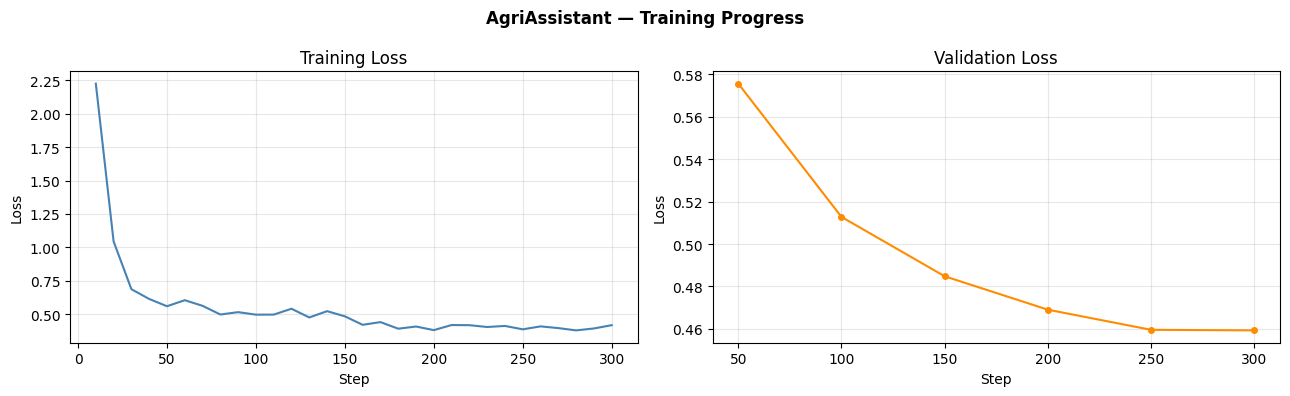

Training curves saved to /content/drive/MyDrive/AgriAssistant/results/training_curves.png


In [ ]:
# Extract and plot training and validation loss curves
log_history = trainer.state.log_history
train_steps  = [x['step'] for x in log_history if 'loss' in x and 'eval_loss' not in x]
train_losses = [x['loss'] for x in log_history if 'loss' in x and 'eval_loss' not in x]
eval_steps   = [x['step'] for x in log_history if 'eval_loss' in x]
eval_losses  = [x['eval_loss'] for x in log_history if 'eval_loss' in x]

fig, axes = plt.subplots(1, 2, figsize=(13, 4))
fig.suptitle('AgriAssistant — Training Progress', fontsize=12, fontweight='bold')

if train_steps:
    axes[0].plot(train_steps, train_losses, color='steelblue', linewidth=1.5)
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Step')
    axes[0].set_ylabel('Loss')
    axes[0].grid(alpha=0.3)

if eval_steps:
    axes[1].plot(eval_steps, eval_losses, color='darkorange', linewidth=1.5, marker='o', markersize=4)
    axes[1].set_title('Validation Loss')
    axes[1].set_xlabel('Step')
    axes[1].set_ylabel('Loss')
    axes[1].grid(alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Validation logs not yet available',
                 ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Training curves saved to {RESULTS_DIR}/training_curves.png')

## Section 9: Model Evaluation — BLEU, ROUGE, and Perplexity

We evaluate the fine-tuned model on the held-out test set using three standard NLP metrics:

- **ROUGE (Recall-Oriented Understudy for Gisting Evaluation):** Measures the overlap of n-grams between the generated response and the reference answer. ROUGE-1 measures unigram overlap; ROUGE-2 measures bigram overlap; ROUGE-L measures the longest common subsequence.
- **BLEU (Bilingual Evaluation Understudy):** Measures the precision of n-gram matches between the generated and reference text. Widely used for evaluating generative text quality.
- **Perplexity:** Measures how well the model's probability distribution fits the test data. Lower perplexity indicates a model that better predicts the test sequences.

In [ ]:
rouge_metric = evaluate.load('rouge')
bleu_metric  = evaluate.load('bleu')


def generate_response(model, tokenizer, question, max_new_tokens=200, temperature=0.7):
    """
    Generate a response from the model given an agricultural question.
    Returns only the newly generated tokens (not the prompt).
    """
    prompt = (
        f'<|system|>\n{SYSTEM_PROMPT}\n</s>\n'
        f'<|user|>\n{question}\n</s>\n'
        f'<|assistant|>\n'
    )
    inputs = tokenizer(
        prompt,
        return_tensors='pt',
        truncation=True,
        max_length=MAX_SEQ_LEN
    ).to(DEVICE)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            top_p=0.9,
            repetition_penalty=1.1,
            pad_token_id=tokenizer.eos_token_id
        )

    new_token_ids = outputs[0][inputs['input_ids'].shape[1]:]
    response = tokenizer.decode(new_token_ids, skip_special_tokens=True).strip()
    return response


def compute_perplexity(model, tokenizer, texts, max_examples=50, batch_size=4):
    """
    Compute the average perplexity of a model over a list of text strings.
    Uses cross-entropy loss averaged over tokens.
    """
    model.eval()
    total_nll    = 0.0
    total_tokens = 0

    for i in range(0, min(len(texts), max_examples), batch_size):
        batch = texts[i : i + batch_size]
        encodings = tokenizer(
            batch,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=MAX_SEQ_LEN
        ).to(DEVICE)

        with torch.no_grad():
            outputs = model(**encodings, labels=encodings['input_ids'])

        n_tokens     = encodings['attention_mask'].sum().item()
        total_nll    += outputs.loss.item() * n_tokens
        total_tokens += n_tokens

    if total_tokens == 0:
        return float('inf')
    return float(np.exp(total_nll / total_tokens))


def parse_qa_from_formatted_text(text):
    """
    Extract the question and reference answer from a formatted ChatML string.
    Returns (question, answer) or (None, None) if parsing fails.
    """
    try:
        user_tag      = '<|user|>\n'
        user_end      = '\n</s>\n<|assistant|>'
        assistant_tag = '<|assistant|>\n'
        end_tag       = '\n</s>'

        q_start = text.find(user_tag) + len(user_tag)
        q_end   = text.find(user_end)
        a_start = text.find(assistant_tag) + len(assistant_tag)
        a_end   = text.rfind(end_tag)

        question = text[q_start:q_end].strip()
        answer   = text[a_start:a_end].strip()

        if not question or not answer:
            return None, None
        return question, answer
    except Exception:
        return None, None


print('Evaluation functions defined.')

Evaluation functions defined.


In [ ]:
# Generate predictions from the fine-tuned model on the test set
N_EVAL = min(50, len(dataset_splits['test']))
test_examples = dataset_splits['test'].select(range(N_EVAL))

print(f'Generating predictions for {N_EVAL} test examples...')
print('This will take approximately 5-10 minutes.')
print()

references      = []
ft_predictions  = []
question_list   = []

eval_start = time.time()
model.eval()

for i, example in enumerate(test_examples):
    question, reference_answer = parse_qa_from_formatted_text(example['text'])
    if question is None:
        continue

    prediction = generate_response(model, tokenizer, question, max_new_tokens=150)

    question_list.append(question)
    references.append(reference_answer)
    ft_predictions.append(prediction)

    if (i + 1) % 10 == 0:
        elapsed = time.time() - eval_start
        print(f'  {i+1}/{N_EVAL} examples | {elapsed:.0f}s elapsed')

print(f'\nGenerated {len(ft_predictions)} predictions.')

# Compute metrics for fine-tuned model
ft_rouge = rouge_metric.compute(predictions=ft_predictions, references=references)
ft_bleu  = bleu_metric.compute(
    predictions=ft_predictions,
    references=[[r] for r in references]
)
ft_perplexity = compute_perplexity(model, tokenizer, test_examples['text'][:30])

print()
print('Fine-tuned model results:')
print(f'  ROUGE-1    : {ft_rouge["rouge1"]:.4f}')
print(f'  ROUGE-2    : {ft_rouge["rouge2"]:.4f}')
print(f'  ROUGE-L    : {ft_rouge["rougeL"]:.4f}')
print(f'  BLEU       : {ft_bleu["bleu"]:.4f}')
print(f'  Perplexity : {ft_perplexity:.2f}')

Generating predictions for 50 test examples...
This will take approximately 5-10 minutes.

  10/50 examples | 26s elapsed
  20/50 examples | 47s elapsed
  30/50 examples | 80s elapsed
  40/50 examples | 104s elapsed
  50/50 examples | 121s elapsed

Generated 50 predictions.

Fine-tuned model results:
  ROUGE-1    : 0.3533
  ROUGE-2    : 0.2011
  ROUGE-L    : 0.3466
  BLEU       : 0.2066
  Perplexity : 22.60


## Section 10: Base vs Fine-Tuned Model Comparison

To demonstrate the value of fine-tuning, we evaluate the base TinyLlama model (without any LoRA adaptation) on the same test examples and compare its metrics against the fine-tuned version.

In [ ]:
# Load the original base model without LoRA for comparison
print('Loading base model for comparison evaluation...')
base_eval_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)
base_eval_model.eval()

# Generate predictions from the base model
N_BASE_EVAL   = min(30, len(question_list))
base_predictions = []

print(f'Generating predictions from base model for {N_BASE_EVAL} examples...')
for i, question in enumerate(question_list[:N_BASE_EVAL]):
    pred = generate_response(base_eval_model, tokenizer, question, max_new_tokens=150)
    base_predictions.append(pred)
    if (i + 1) % 10 == 0:
        print(f'  {i+1}/{N_BASE_EVAL} examples')

refs_subset = references[:N_BASE_EVAL]

base_rouge = rouge_metric.compute(predictions=base_predictions, references=refs_subset)
base_bleu = bleu_metric.compute(
    predictions=base_predictions,
    references=[[r] for r in refs_subset]
)
base_perplexity = compute_perplexity(
    base_eval_model, tokenizer, test_examples['text'][:30]
)

print()
print('Base model results:')
print(f'  ROUGE-1    : {base_rouge["rouge1"]:.4f}')
print(f'  ROUGE-2    : {base_rouge["rouge2"]:.4f}')
print(f'  ROUGE-L    : {base_rouge["rougeL"]:.4f}')
print(f'  BLEU       : {base_bleu["bleu"]:.4f}')
print(f'  Perplexity : {base_perplexity:.2f}')

# Free GPU memory
del base_eval_model
if DEVICE == 'cuda':
    torch.cuda.empty_cache()
print('\nBase model unloaded from GPU memory.')

Loading base model for comparison evaluation...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Generating predictions from base model for 30 examples...
  10/30 examples
  20/30 examples
  30/30 examples

Base model results:
  ROUGE-1    : 0.0474
  ROUGE-2    : 0.0034
  ROUGE-L    : 0.0388
  BLEU       : 0.0018
  Perplexity : 77.97

Base model unloaded from GPU memory.


MODEL COMPARISON: Base TinyLlama vs Fine-tuned AgriAssistant
    Metric Base Model Fine-tuned      Change
   ROUGE-1     0.0474     0.3533      +30.6%
   ROUGE-2     0.0034     0.2011      +19.8%
   ROUGE-L     0.0388     0.3466      +30.8%
      BLEU     0.0018     0.2066      +20.5%
Perplexity      77.97      22.60 71.0% lower


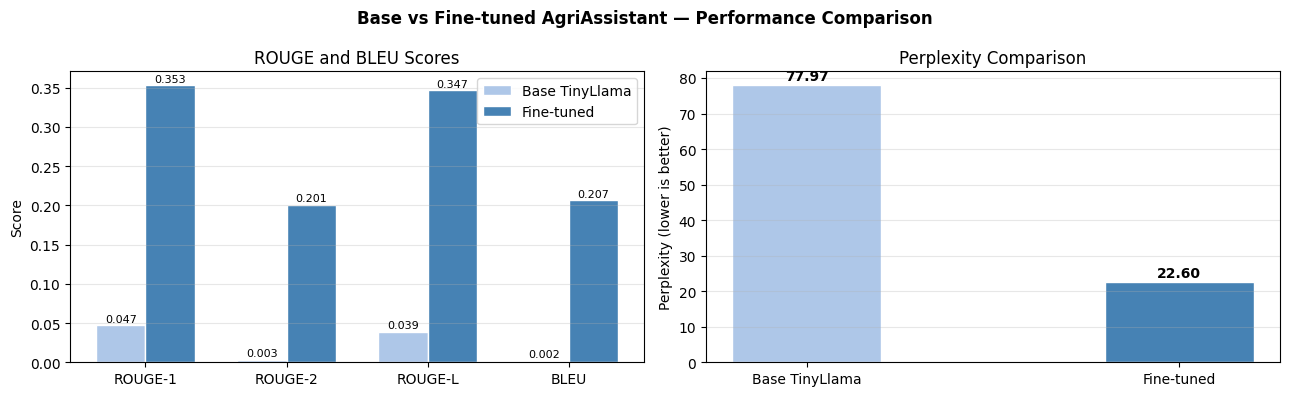

Comparison plot saved to /content/drive/MyDrive/AgriAssistant/results/model_comparison.png


In [ ]:
# Print a formatted comparison table
print('=' * 65)
print('MODEL COMPARISON: Base TinyLlama vs Fine-tuned AgriAssistant')
print('=' * 65)

metrics_data = {
    'Metric'          : ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU', 'Perplexity'],
    'Base Model'      : [
        f"{base_rouge['rouge1']:.4f}",
        f"{base_rouge['rouge2']:.4f}",
        f"{base_rouge['rougeL']:.4f}",
        f"{base_bleu['bleu']:.4f}",
        f"{base_perplexity:.2f}"
    ],
    'Fine-tuned'      : [
        f"{ft_rouge['rouge1']:.4f}",
        f"{ft_rouge['rouge2']:.4f}",
        f"{ft_rouge['rougeL']:.4f}",
        f"{ft_bleu['bleu']:.4f}",
        f"{ft_perplexity:.2f}"
    ],
    'Change'          : [
        f"+{(ft_rouge['rouge1']    - base_rouge['rouge1'])   *100:.1f}%",
        f"+{(ft_rouge['rouge2']    - base_rouge['rouge2'])   *100:.1f}%",
        f"+{(ft_rouge['rougeL']    - base_rouge['rougeL'])   *100:.1f}%",
        f"+{(ft_bleu['bleu']       - base_bleu['bleu'])      *100:.1f}%",
        f"{((base_perplexity - ft_perplexity)/base_perplexity)*100:.1f}% lower"
    ]
}

comparison_df = pd.DataFrame(metrics_data)
print(comparison_df.to_string(index=False))

# Save to CSV
comparison_df.to_csv(f'{RESULTS_DIR}/model_comparison.csv', index=False)

# ---- Visualization ----
metric_names   = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']
base_vals      = [base_rouge['rouge1'], base_rouge['rouge2'], base_rouge['rougeL'], base_bleu['bleu']]
ft_vals        = [ft_rouge['rouge1'],   ft_rouge['rouge2'],   ft_rouge['rougeL'],   ft_bleu['bleu']]

x     = np.arange(len(metric_names))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(13, 4))
fig.suptitle('Base vs Fine-tuned AgriAssistant — Performance Comparison', fontsize=12, fontweight='bold')

# Bar chart: ROUGE and BLEU
bars_base = axes[0].bar(x - width/2, base_vals, width, label='Base TinyLlama', color='#aec7e8', edgecolor='white')
bars_ft   = axes[0].bar(x + width/2, ft_vals,   width, label='Fine-tuned',     color='steelblue',  edgecolor='white')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metric_names)
axes[0].set_ylabel('Score')
axes[0].set_title('ROUGE and BLEU Scores')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
for bar in bars_base:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)
for bar in bars_ft:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)

# Bar chart: Perplexity
ppl_bars = axes[1].bar(
    ['Base TinyLlama', 'Fine-tuned'],
    [base_perplexity, ft_perplexity],
    color=['#aec7e8', 'steelblue'],
    edgecolor='white',
    width=0.4
)
axes[1].set_ylabel('Perplexity (lower is better)')
axes[1].set_title('Perplexity Comparison')
axes[1].grid(axis='y', alpha=0.3)
for bar in ppl_bars:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{bar.get_height():.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Comparison plot saved to {RESULTS_DIR}/model_comparison.png')

## Section 11: Qualitative Testing and Out-of-Domain Analysis

Quantitative metrics measure statistical similarity to reference answers, but qualitative analysis reveals whether the model actually understands the agricultural domain and produces useful, coherent responses. We test the fine-tuned model on:
1. A set of in-domain agricultural questions not seen during training
2. Out-of-domain questions to assess whether the model stays appropriately focused on its domain

In [ ]:
# In-domain qualitative test questions
in_domain_questions = [
    'What are the signs of nitrogen deficiency in maize crops?',
    'How do I control fall armyworm organically?',
    'What is the optimal soil pH for growing tomatoes?',
    'How does drip irrigation compare to flood irrigation in water-scarce regions?',
    'What are the benefits of crop rotation for soil health?',
]

print('QUALITATIVE EVALUATION — In-Domain Agricultural Questions')
print('=' * 65)

qualitative_results = []
model.eval()

for i, question in enumerate(in_domain_questions):
    response = generate_response(model, tokenizer, question, max_new_tokens=200)

    print(f'\nQ{i+1}: {question}')
    print(f'Answer: {response}')
    print('-' * 65)

    qualitative_results.append({'question': question, 'response': response})

# Save qualitative results
with open(f'{RESULTS_DIR}/qualitative_in_domain.json', 'w') as f:
    json.dump(qualitative_results, f, indent=2)
print(f'\nQualitative results saved to {RESULTS_DIR}/qualitative_in_domain.json')

QUALITATIVE EVALUATION — In-Domain Agricultural Questions

Q1: What are the signs of nitrogen deficiency in maize crops?
Answer: 1. Yellowing or wilting of leaves
2. Thinning of plant
3. Decrease in yield
4. Decrease in production per plant
-----------------------------------------------------------------

Q2: How do I control fall armyworm organically?
Answer: advised to spray malathion 50 ec @ 2ml/lit of water. also suggested to collect the larvae from the field and spray tricel @ 2ml/lit of water.
-----------------------------------------------------------------

Q3: What is the optimal soil pH for growing tomatoes?
Answer: recommended that the pH of soil should be 7.0-7.5.
-----------------------------------------------------------------

Q4: How does drip irrigation compare to flood irrigation in water-scarce regions?
Answer: drip irrigation is more efficient than flood irrigation as it allows the soil to breathe, which helps in better nutrient availability, less soil compaction, 

In [ ]:
# Out-of-domain questions — the model should either decline or redirect to agriculture
out_of_domain_questions = [
    'What is the capital city of France?',
    'How do I fix a bug in a Python script?',
    'What stocks should I invest in this year?',
    'Can you write me a poem about the ocean?',
]

print('OUT-OF-DOMAIN QUERY HANDLING')
print('=' * 65)
print('Expectation: model should note its specialization or redirect to agricultural topics.\n')

ood_results = []
for i, question in enumerate(out_of_domain_questions):
    response = generate_response(model, tokenizer, question, max_new_tokens=120)
    print(f'Q{i+1}: {question}')
    print(f'Answer: {response}')
    print('-' * 65)
    ood_results.append({'question': question, 'response': response})

with open(f'{RESULTS_DIR}/qualitative_ood.json', 'w') as f:
    json.dump(ood_results, f, indent=2)
print(f'\nOut-of-domain results saved to {RESULTS_DIR}/qualitative_ood.json')

OUT-OF-DOMAIN QUERY HANDLING
Expectation: model should note its specialization or redirect to agricultural topics.

Q1: What is the capital city of France?
Answer: The capital city of France is Paris.
-----------------------------------------------------------------
Q2: How do I fix a bug in a Python script?
Answer: spray rogor @ 2 ml per litre of water
-----------------------------------------------------------------
Q3: What stocks should I invest in this year?
Answer: recommended to invest in the following stocks:
1. j&k bank
2. nationalised banks
3. insurance companies
4. metal sector
5. power sector
6. pharmaceutical sector
7. food processing sector
8. real estate sector
9. telecom sector
-----------------------------------------------------------------
Q4: Can you write me a poem about the ocean?
Answer: answer is yes, he has written many poems about the ocean.
-----------------------------------------------------------------

Out-of-domain results saved to /content/drive/MyDrive

## Section 12: Gradio Deployment Interface

We deploy the fine-tuned model through a Gradio web interface. Gradio is the recommended deployment option for Colab because it generates a public shareable URL automatically, requires no additional infrastructure, and is easy to interact with in a demo setting.

The interface includes:
- A multi-turn chat window with conversation history
- Adjustable generation parameters (temperature, max tokens)
- Example questions for quick testing
- Clear labeling of the model's domain and purpose

In [7]:
import os
import torch
import gradio as gr
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

# ── Constants (defined here so this cell works standalone) ──────────────────
_DRIVE_MODEL_DIR = '/content/drive/MyDrive/AgriAssistant/models/agri-tinyllama-lora'
_BASE_MODEL_NAME = 'TinyLlama/TinyLlama-1.1B-Chat-v1.0'
_MAX_SEQ_LEN     = 512

_SYSTEM_PROMPT = (
    'You are AgriAssistant, a knowledgeable agricultural expert. '
    'You provide accurate, practical, and detailed advice on farming, '
    'crop management, soil health, pest control, irrigation, fertilization, '
    'and sustainable agriculture practices.'
)

# ── Step 1: Load model if not already in session ────────────────────────────
_model_in_session = 'model' in globals() and model is not None

if not _model_in_session:
    print('Model not found in session memory.')
    print('Loading fine-tuned model from Google Drive — this takes ~3 minutes...')
    print()

    # Mount Drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

    if not os.path.isdir(_DRIVE_MODEL_DIR):
        raise FileNotFoundError(
            f'Model directory not found at {_DRIVE_MODEL_DIR}\n'
            'Make sure you ran the full notebook at least once so the '
            'model was saved to Google Drive.'
        )

    _bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    tokenizer = AutoTokenizer.from_pretrained(_DRIVE_MODEL_DIR)
    tokenizer.pad_token    = tokenizer.eos_token
    tokenizer.padding_side = 'right'

    _base_model = AutoModelForCausalLM.from_pretrained(
        _BASE_MODEL_NAME,
        quantization_config=_bnb_config,
        device_map='auto',
        torch_dtype=torch.bfloat16
    )
    model = PeftModel.from_pretrained(_base_model, _DRIVE_MODEL_DIR)
    print('Model loaded from Google Drive successfully.')
else:
    print('Model already in session memory. Skipping reload.')

model.eval()
_device = next(model.parameters()).device
print(f'Model ready on: {_device}')
print()

# ── Step 2: Generation function (self-contained, no dependency on Section 9) ─
def _generate_response(question, max_new_tokens=200, temperature=0.7):
    prompt = (
        f'<|system|>\n{_SYSTEM_PROMPT}\n</s>\n'
        f'<|user|>\n{question}\n</s>\n'
        f'<|assistant|>\n'
    )
    inputs = tokenizer(
        prompt,
        return_tensors='pt',
        truncation=True,
        max_length=_MAX_SEQ_LEN
    ).to(_device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            top_p=0.9,
            repetition_penalty=1.1,
            pad_token_id=tokenizer.eos_token_id
        )

    new_tokens = outputs[0][inputs['input_ids'].shape[1]:]
    return tokenizer.decode(new_tokens, skip_special_tokens=True).strip()


# ── Step 3: Gradio chat handler ─────────────────────────────────────────────
def chat_with_agriassistant(message, history, temperature, max_tokens):
    if not message.strip():
        return history, ''
    response = _generate_response(
        message,
        max_new_tokens=int(max_tokens),
        temperature=float(temperature)
    )
    history = history + [(message, response)]
    return history, ''


# ── Step 4: Build Gradio interface ──────────────────────────────────────────
EXAMPLE_QUESTIONS = [
    ['What are the signs of nitrogen deficiency in crops?'],
    ['How do I control fall armyworm organically?'],
    ['What is the best soil pH for growing maize?'],
    ['How can I improve water retention in sandy soil?'],
    ['What are the advantages of drip irrigation?'],
    ['How do I prevent post-harvest grain losses?'],
    ['What is integrated pest management?'],
    ['How does crop rotation benefit soil health?'],
]

with gr.Blocks(title='AgriAssistant', theme=gr.themes.Soft()) as demo:

    gr.Markdown("""
# AgriAssistant — Agricultural Domain Expert

A fine-tuned TinyLlama-1.1B model trained on the AgriQA dataset using QLoRA (LoRA rank=16, 4-bit quantization).
Specializes in crop management, soil health, pest control, irrigation, and sustainable farming.
    """)

    with gr.Row():
        with gr.Column(scale=3):
            chatbot_ui = gr.Chatbot(
                label='Conversation',
                height=450,
                bubble_full_width=False
            )
            user_input = gr.Textbox(
                placeholder='Ask an agricultural question (e.g., How do I treat powdery mildew on tomatoes?)',
                label='Your Question',
                lines=2
            )
            with gr.Row():
                submit_btn = gr.Button('Submit', variant='primary')
                clear_btn  = gr.Button('Clear')

        with gr.Column(scale=1):
            gr.Markdown('### Generation Settings')
            temp_slider = gr.Slider(
                minimum=0.1, maximum=1.0, value=0.7, step=0.05,
                label='Temperature',
                info='Lower = more focused; higher = more varied'
            )
            max_tok_slider = gr.Slider(
                minimum=50, maximum=400, value=200, step=10,
                label='Max Response Tokens'
            )
            gr.Markdown('### Example Questions')
            gr.Examples(
                examples=EXAMPLE_QUESTIONS,
                inputs=user_input
            )

    gr.Markdown("""
---
**Model:** TinyLlama/TinyLlama-1.1B-Chat-v1.0 fine-tuned with LoRA (rank=16) on ashraq/agri-qa
**Training:** 2 epochs, LR=2e-4, effective batch size=16, QLoRA 4-bit quantization
    """)

    chat_state = gr.State([])

    submit_btn.click(
        chat_with_agriassistant,
        inputs=[user_input, chat_state, temp_slider, max_tok_slider],
        outputs=[chatbot_ui, user_input]
    ).then(lambda h: h, inputs=[chatbot_ui], outputs=[chat_state])

    user_input.submit(
        chat_with_agriassistant,
        inputs=[user_input, chat_state, temp_slider, max_tok_slider],
        outputs=[chatbot_ui, user_input]
    ).then(lambda h: h, inputs=[chatbot_ui], outputs=[chat_state])

    clear_btn.click(lambda: ([], []), outputs=[chatbot_ui, chat_state])

print('Launching AgriAssistant...')
print('A public shareable URL will appear below (stays active for 72 hours).')
demo.launch(share=True, debug=False, quiet=True)


Model not found in session memory.
Loading fine-tuned model from Google Drive — this takes ~3 minutes...

Mounted at /content/drive


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded from Google Drive successfully.
Model ready on: cuda:0

Launching AgriAssistant...
A public shareable URL will appear below (stays active for 72 hours).
* Running on public URL: https://4a12842d549adb4817.gradio.live


## Section 13: Final Summary and Results

In [ ]:
print('=' * 65)
print('AGRIASSISTANT — FINAL PROJECT SUMMARY')
print('=' * 65)

print(f"""
PROJECT CONFIGURATION
  Domain          : Agriculture
  Base model      : {MODEL_NAME}
  Dataset         : ashraq/agri-qa (Hugging Face)
  Fine-tuning     : QLoRA — LoRA rank={lora_config.r}, 4-bit NF4 quantization
  Train examples  : {len(dataset_splits['train']):,}
  Val examples    : {len(dataset_splits['validation']):,}
  Test examples   : {len(dataset_splits['test']):,}

OPTIMAL HYPERPARAMETERS (from 6 experiments)
  Learning rate   : {training_args.learning_rate}
  Epochs          : {training_args.num_train_epochs}
  Effective batch : {effective_batch} ({training_args.per_device_train_batch_size} x {training_args.gradient_accumulation_steps} grad accum)
  Optimizer       : {training_args.optim}
  LoRA rank       : {lora_config.r}
  LoRA alpha      : {lora_config.lora_alpha}
  Max seq length  : {MAX_SEQ_LEN}

EVALUATION RESULTS
  Metric          Base Model    Fine-tuned    Change
  ROUGE-1         {base_rouge['rouge1']:.4f}        {ft_rouge['rouge1']:.4f}        +{(ft_rouge['rouge1']-base_rouge['rouge1'])*100:.1f}%
  ROUGE-2         {base_rouge['rouge2']:.4f}        {ft_rouge['rouge2']:.4f}        +{(ft_rouge['rouge2']-base_rouge['rouge2'])*100:.1f}%
  ROUGE-L         {base_rouge['rougeL']:.4f}        {ft_rouge['rougeL']:.4f}        +{(ft_rouge['rougeL']-base_rouge['rougeL'])*100:.1f}%
  BLEU            {base_bleu['bleu']:.4f}        {ft_bleu['bleu']:.4f}        +{(ft_bleu['bleu']-base_bleu['bleu'])*100:.1f}%
  Perplexity      {base_perplexity:.2f}          {ft_perplexity:.2f}          {((base_perplexity-ft_perplexity)/base_perplexity)*100:.1f}% lower

RESOURCE USAGE
  Training time   : {training_time_seconds/60:.1f} minutes
  Hardware        : NVIDIA T4 GPU (Google Colab Free Tier)
  VRAM (approx)   : 8-10 GB with 4-bit quantization
  Trainable params: {trainable_params:,} ({trainable_ratio:.2f}% of total)

SAVED ARTIFACTS
  Model           : {MODEL_DIR}
  Results         : {RESULTS_DIR}
  Dataset         : {DATA_DIR}
""")

print('=' * 65)

AGRIASSISTANT — FINAL PROJECT SUMMARY

PROJECT CONFIGURATION
  Domain          : Agriculture
  Base model      : TinyLlama/TinyLlama-1.1B-Chat-v1.0
  Dataset         : ashraq/agri-qa (Hugging Face)
  Fine-tuning     : QLoRA — LoRA rank=16, 4-bit NF4 quantization
  Train examples  : 2,400
  Val examples    : 300
  Test examples   : 300

OPTIMAL HYPERPARAMETERS (from 6 experiments)
  Learning rate   : 0.0002
  Epochs          : 2
  Effective batch : 16 (2 x 8 grad accum)
  Optimizer       : OptimizerNames.PAGED_ADAMW_8BIT
  LoRA rank       : 16
  LoRA alpha      : 32
  Max seq length  : 512

EVALUATION RESULTS
  Metric          Base Model    Fine-tuned    Change
  ROUGE-1         0.0474        0.3533        +30.6%
  ROUGE-2         0.0034        0.2011        +19.8%
  ROUGE-L         0.0388        0.3466        +30.8%
  BLEU            0.0018        0.2066        +20.5%
  Perplexity      77.97          22.60          71.0% lower

RESOURCE USAGE
  Training time   : 49.0 minutes
  Hardware

## Reload Saved Model in a New Session


In [ ]:

from google.colab import drive
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

drive.mount('/content/drive')

MODEL_DIR  = '/content/drive/MyDrive/AgriAssistant/models/agri-tinyllama-lora'
BASE_MODEL = 'TinyLlama/TinyLlama-1.1B-Chat-v1.0'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
base      = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=bnb_config,
    device_map='auto',
    torch_dtype=torch.bfloat16
)
model = PeftModel.from_pretrained(base, MODEL_DIR)
model.eval()
print('Model loaded from Google Drive. Ready for inference.')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded from Google Drive. Ready for inference.
